#### Проект. Рекомендательные системы в банковской сфере. Исследование данных

##### Содержание

 - Начало: импорт библиотек, настройка параметров, определения функций
 - Загрузка данных, общий обзор
 - Создание таргета, сплит на обучающий/тестовый датасеты
 - Выбор метрик
 - Анализ отдельных переменных, вывод закономерностей
 - Определение функции для препроцессинга данных
 - Обзор зависимостей между признаками и таргетом с помощью средств phik, оценка высококардинальных переменных
 - Проверка препроцессинга, формирование шага предобработки общего пайплайна
 - Итоги проведения исследовательского анализа

##### Начало: импорт библиотек, настройка параметров, определения функций

Данные представляют собой csv-файл, загружаемый по ссылке.  
Инструкции по загрузке приведены в README.md.  
Следуя стандартам PEP8, аннотации функций написаны на английском.   
Действия по выполнению проекта назодятся в ячейках markdown.

In [1]:
# Standard library imports
import os
import warnings
from typing import Optional, List, Dict

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import joblib
import phik

# Scikit-learn imports
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, roc_curve, auc)
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline

# CatBoost import
from catboost import CatBoostClassifier

# Local module imports
from data_utils import get_mem_usage, new_columns, attrs

# Environment variable handling
from dotenv import load_dotenv

# Set global plotting and formatting options
plt.rcParams['figure.figsize'] = [20, 6]
np.set_printoptions(precision=4, suppress=True)
pd.options.display.float_format = '{:.4f}'.format

# Constants
RANDOM_STATE = 42
SAMPLE_SIZE = 10**5

# Load environment variables
load_dotenv()

# List of environment variables to load
env_var_names: List[str] = [
    'DATA_DIR', 'DATA_PARQUET', 'DATA_CSV', 
    'TRAIN_PARQUET', 'TEST_PARQUET', 
    'MODEL_DIR', 'MODEL_PKL'
]

# Load each environment variable
for var in env_var_names:
    globals()[var] = os.getenv(var)

# Function to display history of NaNs in a specific column
def display_nans_history(df: pd.DataFrame, col: str) -> None:
    """
    Display the count of missing values (NaNs) in a given column over time.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    col (str): The column to analyze for missing values.
    """
    print(f"Пропущенные значения в столбце {col} ({df.attrs[col][0]})")
    
    summary_df = df.groupby('fetch_date')[col].agg(['count', lambda x: x.isna().sum()])
    summary_df.columns = ['count', 'nan_sum']

    summary_df.reset_index(inplace=True)
    summary_df['fetch_date'] = summary_df['fetch_date'].dt.strftime('%Y-%m-%d')

    total_row = pd.DataFrame({
        'fetch_date': ['Total'],
        'count': [summary_df['count'].sum()],
        'nan_sum': [summary_df['nan_sum'].sum()]
    })
    summary_df = pd.concat([summary_df, total_row], ignore_index=True)

    summary_df.index = [''] * len(summary_df)
    display(summary_df.style.format({
        'count': '{:,.0f}',
        'nan_sum': '{:,.0f}'
    }))

# Function to display basic statistics of the data
def display_statistics(data: pd.DataFrame) -> pd.DataFrame:
    """
    Display basic statistics for each column in the dataframe.
    
    Parameters:
    data (pd.DataFrame): The dataframe to analyze.
    
    Returns:
    pd.DataFrame: A dataframe containing statistics for each column.
    """
    indicators: List[Dict] = []
    
    for col in data.columns:
        indicators.append({
            'type': data[col].dtypes,
            'types': set(map(lambda v: type(v).__name__, data[col].unique())),
            'count': data[col].count(),
            'NaNs': data[col].isna().sum(),
            'zero_values': data[col].eq(0).sum(),
            'nunique': data[col].nunique(),
            'unique-top5': data[col].value_counts().head().to_dict()
        })
    
    return pd.DataFrame(indicators, index=[x for x in data.columns])

##### Загрузка данных, общий обзор

Данные представляю собой обезличенную информацию испанского банка о своих клиентах в разрезе приобретения мим продуктов банка.  
Файл загружается из каталога DATA_DIR, проводится начальный парсинг дат и автоматическое переименование названий колонок с испанского на английский язык из словаря new_columns импортируемого модуля data_utils.  
Поскольку данные в памяти занимают окло 7 Гб, проводится мониторинг свободной памяти с помощью функции get_mem_usage().

In [2]:
if os.path.exists(DATA_DIR + DATA_PARQUET):
    df: pd.DataFrame = pd.read_parquet(DATA_DIR + DATA_PARQUET)
    print(f"Файл {DATA_DIR + DATA_PARQUET} существует и был открыт.")

else:
    dtype_spec: dict = {
        'age': 'str',
        'tenure_months': 'str',
        'client_type_1m': 'str',
        'ind_spouse_employee': 'str',
    }

    df = pd.read_csv(
        DATA_DIR + DATA_CSV, 
        dtype=dtype_spec,
        parse_dates=['fetch_date', 'registration_date', 'last_date_as_primary'],
        date_format='%Y-%m-%d',
        low_memory=False,
        header=0,
        names=list(new_columns.values())
    )

    df.attrs = attrs
    df.to_parquet(DATA_DIR + DATA_PARQUET)
    print(f"Файл данных {DATA_DIR + DATA_PARQUET} был сгенерирован и сохранен.")

display(df.head())
get_mem_usage()

Файл данных data/data.parquet был сгенерирован и сохранен.


,fetch_date,id,ind_employee,country_of_residence,gender,age,registration_date,ind_new_client,tenure_months,client_relationship_status,...,ind_1m_mortgage,ind_1m_pension_plan,ind_1m_loans,ind_1m_tax_account,ind_1m_credit_card,ind_1m_securities,ind_1m_home_acc,ind_1m_salary_acc,ind_1m_pension_obligation_account,ind_1m_debit_account
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0000,6,1.0000,...,0,0,0,0,0,0,0,0.0000,0.0000,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0000,35,1.0000,...,0,0,0,0,0,0,0,0.0000,0.0000,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0000,35,1.0000,...,0,0,0,0,0,0,0,0.0000,0.0000,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0000,35,1.0000,...,0,0,0,0,0,0,0,0.0000,0.0000,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0000,35,1.0000,...,0,0,0,0,0,0,0,0.0000,0.0000,0


Общая память: 33.7 GB
Доступная память: 21.6 GB


Данные успешно загружены, посмотрим на их структуру.

In [3]:
display_statistics(df)

,type,types,count,NaNs,zero_values,nunique,unique-top5
fetch_date,datetime64[ns],{Timestamp},13647309,0,0,17,"{2016-05-28 00:00:00: 931453, 2016-04-28 00:00..."
id,int64,{int64},13647309,0,0,956645,"{538031: 17, 538018: 17, 538021: 17, 538023: 1..."
ind_employee,object,"{str, float}",13619575,27734,0,5,"{'N': 13610977, 'B': 3566, 'F': 2523, 'A': 249..."
country_of_residence,object,"{str, float}",13619575,27734,0,118,"{'ES': 13553710, 'FR': 5161, 'AR': 4835, 'DE':..."
gender,object,"{str, float}",13619505,27804,0,2,"{'V': 7424252, 'H': 6195253}"
age,object,{str},13647309,0,0,121,"{' 23': 779884, ' 22': 736314, ' 24': 734785, ..."
registration_date,datetime64[ns],"{NaTType, Timestamp}",13619575,27734,0,6756,"{2014-07-28 00:00:00: 57389, 2014-10-03 00:00:..."
ind_new_client,float64,{float64},13619575,27734,12808368,2,"{0.0: 12808368, 1.0: 811207}"
tenure_months,object,{str},13647309,0,0,259,"{' 12': 243160, ' 21': 214795, ' 1..."
client_relationship_status,float64,{float64},13619575,27734,0,2,"{1.0: 13594782, 99.0: 24793}"


Данных много, но они однотипные.   
Можно выделить:  
 - 3 числовые переменные (в том числе и по смыслу) age, tenure_months, income  
 - 17 категориальных переменных с разной кардинальностью
 - 24 бинарных переменных с шаблоном названий ind_1m_*, которые и являются целью предсказаний
 - 3 даты и 1 колонка id  
   
Много пропусков встречается в переменных last_date_as_primary, ind_spouse_employee, income.  
Для большинства переменных характерен заметный дисбаланс, встречаются нерелеваннтные признаки (address_type).  
Данные очень разрежены, особенно у индикаторных признаков ind_1m_*.    
  
Данные поддаются анализу, но сначала нужно определиться с таргетом.

##### Создание таргета, сплит на обучающий/тестовый датасеты

Цель сервиса - предсказать продукты, которые клиент приобретет в следующем периоде. Другими словами, тренировочные данными будут сведения о купленных продуктах до текущего месяца, а таргетом - сведения о вновь приобретенных продуктах в следующем месяце.  

In [4]:
def count_changes(grouped: pd.Series, type: int = 0) -> int:
    """
    Count the number of changes in a grouped pandas Series.

    Parameters:
    grouped (pd.Series): The Series containing grouped data.
    type (int, optional): The type of change to count. 
                          If 0, counts all non-zero changes. 
                          If other, counts changes to that specific value. Default is 0.

    Returns:
    int: The total count of changes in the grouped Series.
    """
    # Calculate the difference between consecutive rows in the grouped data
    diffs = grouped.diff()

    # If type is 0, count all non-zero changes; otherwise, count changes to the specific value (type)
    if type == 0:
        changes = diffs.ne(0) & diffs.notna()
    else:
        changes = diffs.eq(type) & diffs.notna()

    # Group by 'id' column and sum the changes for each group, then sum the total changes
    changes_count = changes.groupby(df['id']).sum()
    
    return changes_count.sum().sum()

Мы определили функцию, которая считает различия в сгруппированных данных.  
Выведем возможные изменения и статистики покупок продуктов в данных, сгруппированных по клиентам ('id').

In [5]:
product_features = [col for col in df.columns if col.startswith('ind_1m_')]

grouped = df.groupby('id')[product_features]

num_of_periods = df['fetch_date'].nunique()
num_of_clients = df['id'].nunique()
num_of_interactions = grouped.sum().sum(axis=1).mean()

print(f"Среднее количество периодов пользования продуктами: {num_of_interactions:.2f} в течение {num_of_periods} периодов")
print(f"Среднее количество продуктов на одного клиента: {grouped.mean().sum(axis=1).mean():.2f}")
print(f"Доля клиентов, пользующихся в среднем не более, чем одним продуктом: {(grouped.mean().sum(axis=1) <=1).mean():.2%}")

sum_of_interactions = grouped.sum().sum(axis=1)
print(f"Доля клиентов, не пользующихся никакими продуктами: {(sum_of_interactions ==0).mean():.2%}")
print()

print(f"Доля клиентов, у которых в начале и в конце истории одинаковый набор продуктов: "
        f"{(grouped.first() == grouped.last()).all(axis=1).sum() / num_of_clients:.2%},")
print(f"Доля клиентов, у которых ни разу не менялся набор продуктов: "
        f"{(grouped.first() == grouped.mean()).all(axis=1).sum() / num_of_clients:.2%}")
print()

interactions_total = df[product_features].count().sum() - grouped.first().count().sum() # без первых строк, которые изменениями не являются

previous_values = grouped.shift(1)
continue_0 = ((previous_values == 0) & (df[product_features] == 0)).sum().sum()
continue_1 = ((previous_values == 1) & (df[product_features] == 1)).sum().sum()
changes = count_changes(grouped)
change_0_1 = count_changes(grouped, 1)
change_1_0 = count_changes(grouped, -1)

print(f"Всего взаимодействий: {interactions_total:,.0f} (100%),\n"
      f" - с изменением состояния: {changes:,.0f} ({changes / interactions_total:.2%}):\n"
      f" - - из них покупок (0->1): {change_0_1:,.0f} ({change_0_1 / interactions_total:.2%}),\n"
      f" - - отказов от услуг (1->0): {change_1_0:,.0f} ({change_1_0 / interactions_total:.2%}),\n"
      f" - без изменения состояния: {continue_0+continue_1:,.0f} ({(continue_0+continue_1) / interactions_total:.2%}):\n"
      f" - - продолжили пользоваться (1->1): {continue_1:,.0f} ({continue_1 / interactions_total:.2%}),\n"
      f" - - продолжили не пользоваться (0->0): {continue_0:,.0f} ({continue_0 / interactions_total:.2%})")

del previous_values

Среднее количество периодов пользования продуктами: 20.86 в течение 17 периодов
Среднее количество продуктов на одного клиента: 1.30
Доля клиентов, пользующихся в среднем не более, чем одним продуктом: 70.54%
Доля клиентов, не пользующихся никакими продуктами: 23.57%

Доля клиентов, у которых в начале и в конце истории одинаковый набор продуктов: 79.94%,
Доля клиентов, у которых ни разу не менялся набор продуктов: 74.56%

Всего взаимодействий: 304,550,014 (100%),
 - с изменением состояния: 1,097,241 (0.36%):
 - - из них покупок (0->1): 563,308 (0.18%),
 - - отказов от услуг (1->0): 533,933 (0.18%),
 - без изменения состояния: 303,452,381 (99.64%):
 - - продолжили пользоваться (1->1): 18,174,160 (5.97%),
 - - продолжили не пользоваться (0->0): 285,278,221 (93.67%)


Данные, как было отмечено, разреженные.  
Каждый пользователь в среднем пользуется одним продуктом за 17 месяцев, таких клиентов ~ 70%.   
Примечательно, что четверть клиентов не пользуются никакими продуктами.  
А за весь период данных 3/4 клиентов ничего не покупали и ни от чего не отказывались.  

Отсюда следует, какие у нас данные, как их фильтровать и как формировать таргет.  
Будем считать взаимодействием пользователя и продукта число 1 или 0, соответствующее факту покупки (пользования) или непользования клиентом данного продукта.  
Тогда два последовательных взаимодействия 0->1 будут означать новую покупку, 1->0 - отказ от продукта, взаимодействия 0->0 и 1->1 не изменяют состояние клиента.  
И из 300 млн взаимодействий всего лишь 0.18% (0->1) относятся к нашему таргету.  
Таргетом для текущего периода будет набор всех продуктов, которыми будет пользоваться клиент в следующем периоде. 
  
Итак, получим таргет сдвигом данных о продуктах на -1, т.е. на предыдущий период.  Обозначим новые столбцы как 'target__*',   
а также удалим ненужные последние строки в каждой группе (для них нет таргета).  
И оставим только тех клиентов, у которых была хотя бы 1 покупка за весь период.  
Остальные данные не сильно помогут в плане предсказания, поскольку отражают довольно устойчивую картину "неприобретения" клиентами продуктов банка.

In [6]:
#grouped = df.groupby('id')[product_features]

shifted_values = grouped.shift(-1)
df_targets = ((df[product_features] == 0) & (shifted_values == 1)).astype(int).add_prefix('target__')

for col in df_targets.columns:
    df[col] = df_targets[col]

del shifted_values, df_targets

targets = [col for col in df.columns if col.startswith("target__")]

last_row_mask = df.groupby('id')['id'].transform('shift', -1).notna()
df = df[last_row_mask]

grouped_0 = (df.groupby('id')[targets].sum().sum(axis=1) == 0)
df = df[~df.id.isin(grouped_0[grouped_0].index)]

df.attrs['target__'] = targets

get_mem_usage()

Общая память: 33.7 GB
Доступная память: 18.3 GB


Данные охватывают период с '2015-01-28' по '2016-05-28', или 17 месяцев. Последний месяц выпадает, т.к. у него нет таргета.  
Возьмем в качестве тестовых данных последние два месяца - с '2016-03-28' по '2016-04-28', остальные данные будут тренировочные.

In [7]:
split_date = '2016-02-28'

df[df.fetch_date > split_date].to_parquet(DATA_DIR + TEST_PARQUET)
df = df[df.fetch_date <= split_date]
df.to_parquet(DATA_DIR + TRAIN_PARQUET)

Мы сразу разделили необработанные данные на тестовую и обучающую выборки для того, чтобы потом обработать их единообразно одним и тем же пайплайном. 

##### Выбор метрик

Итак, перед нами стоит задача многозначной (multi-labeled) классификации при условии сильного дисбаланса.  
Классическая Accuracy не подойдет - любая модель, даже константная, будет показывать высокие значения Accuracy, т.к. будет хорошо определять мажоритарный класс (0).   
Более информативна метрика Precision, которая будет отражать соответсвие false-positive (FP) и true-positive (TP), то есть покажет нам долю правильных предсказаний даже если предсказаний будет мало.  
Также информативна будет метрика Recall, которая TP среди всех положительных меток в данных, даже если их мало.  
Тогда и производные (F1, PR - AUC) также будут информативна.  
ROC-AUC отразит способность модели различать классы.   
В общем, выбор есть.  
Нужно только отметить, что нам больше подойдут микро-усредненные метрики. Если классы очень разные, то макро-усреднение по классам уравняет их, даст больший вес малопредставительным классам, а нам нужна все-таки общая картина, у нас нет предпочтений для выделения какого-нибудь класса.  
Итак, Recall, Precision, F1, ROC-AUC, акцент на микро-усреднение.

##### Анализ отдельных переменных, вывод закономерностей

Получим некоторые простые показатели датасета, например, динамику новых уникальных пользователей

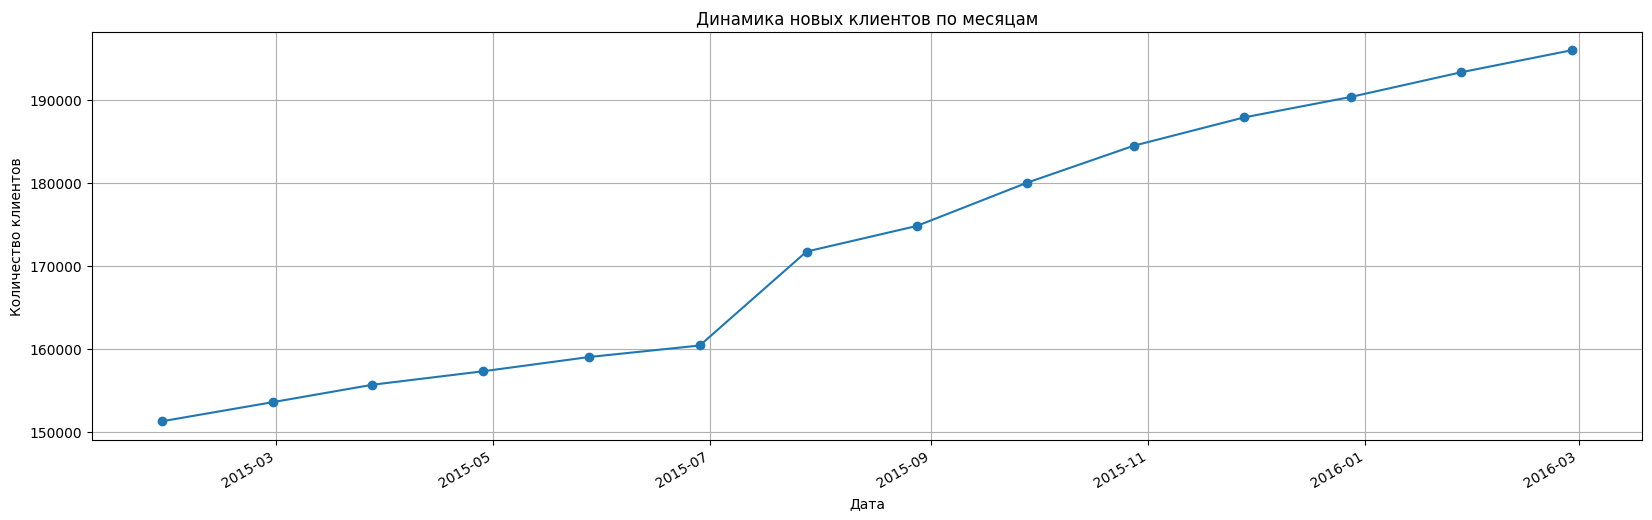

In [8]:
df.groupby('fetch_date')['id'].nunique().plot.line(marker = 'o')

plt.title('Динамика новых клиентов по месяцам')
plt.xlabel('Дата')
plt.ylabel('Количество клиентов')
plt.grid(True)

Видим, что после '2015-07-28' произошло некое заметное изменение.  
Оценим баланс продуктовх переменных (к которым относится и таргет).

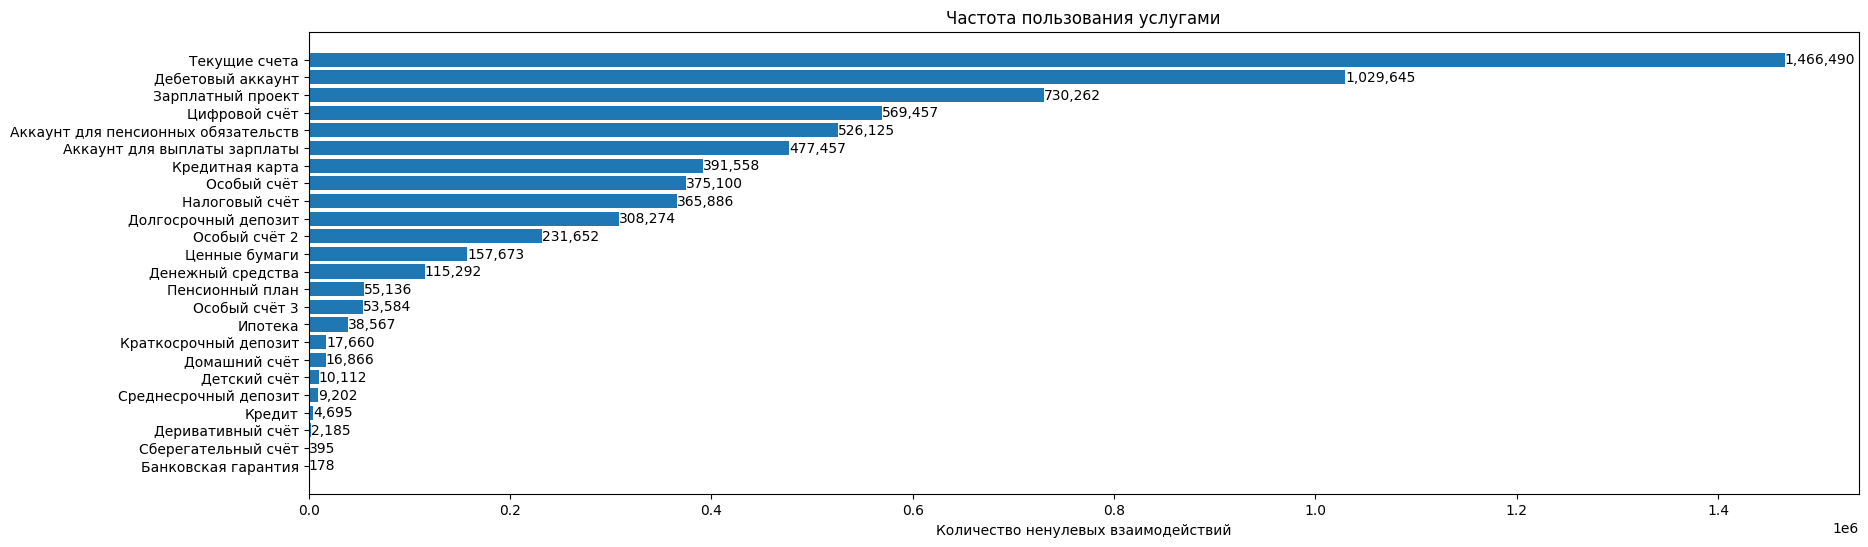

In [9]:
interactions_products = df[product_features].sum().to_frame().sort_values(0)

values = interactions_products[0]
category = interactions_products.index.map(lambda x: interactions_products.attrs[x][0])

plt.figure(figsize=(20,6))
plt.barh(category, values)

for index, value in enumerate(values):
    plt.text(value, index, f"{value:,.0f}", va='center')

plt.xlabel('Количество ненулевых взаимодействий')
plt.title('Частота пользования услугами')
plt.show()

Видим, что периоды пользования разыми продуктами отличаются на несколько порядков. Помимо разреженности всех данных, имеется еще и серьезный дисбаланс между признаками.  
Посмотрим на динамику приобретения / отказов пользования продуктами.

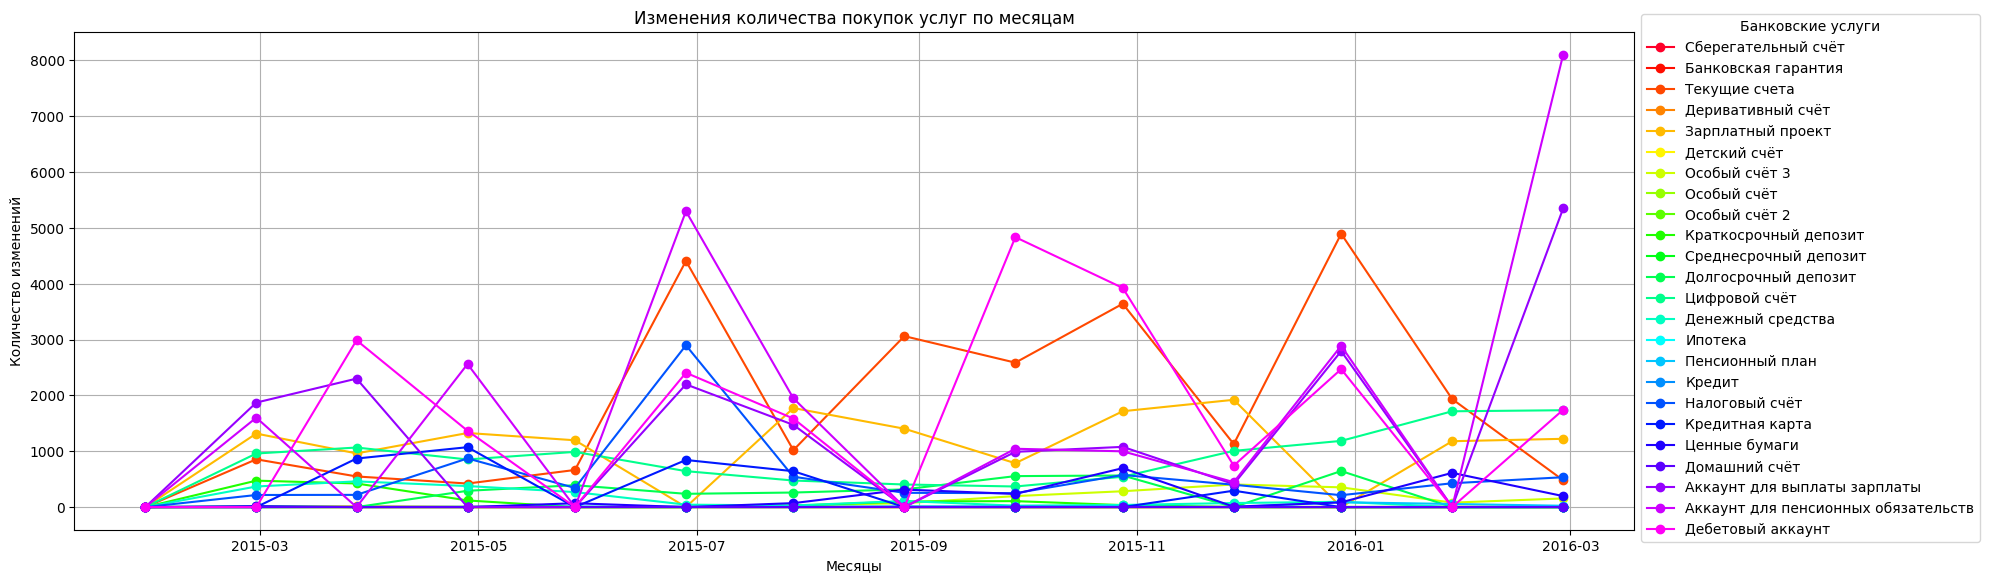

In [10]:
df_targets = df[['fetch_date'] + product_features].set_index('fetch_date')

increments_df = df_targets.groupby('fetch_date').sum().diff().fillna(0) 
increments_df = increments_df[increments_df > 0].fillna(0)

plt.figure(figsize=(20, 6))

num_colors = increments_df.shape[1]
cmap = plt.colormaps.get_cmap('gist_rainbow')

for i, column in enumerate(increments_df.columns):
    color = cmap(i / num_colors) 
    plt.plot(increments_df.index, increments_df[column], marker='o', color=color, label=df.attrs[column][0])

plt.title('Изменения количества покупок услуг по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Количество изменений')
plt.legend(title='Банковские услуги', bbox_to_anchor=(1, 1.05), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

del df_targets

Отсюда можно сделать вывод, что явной сезонности или долгосрочного тренда не наблюдается.  Возможно, поменялся размах значений новых покупок в связи с увеличением количества пользователей.  
  
Оценим структуру пропусков.

In [11]:
nan_counts = df.isna().sum(axis=1)

print(f"Распределение количества NaNs:")
display(nan_counts.value_counts().to_frame())
print(f"Количество строк с NaN > 10: {(nan_counts > 10).sum()}")

Распределение количества NaNs:


,count
2,1997101
3,376222
7,19855
5,9605
6,7984
20,1942
4,1839
1,857
22,433
9,5


Количество строк с NaN > 10: 2375


Строки с большим количеством пропусков (> 10) можно удалить.

In [12]:
display_nans_history(df.loc[nan_counts < 10], 'client_segment')

Пропущенные значения в столбце client_segment (Сегментация)


,fetch_date,count,nan_sum
,2015-01-28,"150,640",29
,2015-02-28,"152,956",24
,2015-03-28,"155,122",20
,2015-04-28,"156,848",11
,2015-05-28,"158,839",8
,2015-06-28,"160,364",0
,2015-07-28,"166,402","5,319"
,2015-08-28,"171,478","3,332"
,2015-09-28,"174,492","5,533"
,2015-10-28,"179,621","4,861"


На примере признака 'client_segment' видно изменение динамики пропусков после того замеченного нами изменения датасета '2015-07-28'. Произошло присоединение большого количества клиентов с повышенным содержанием пропущенных данных.  
Общая картина пропусков некритическая - большинство строк с пропусками имеют 2-3 NaN, которые относятся к упомянутым ранее переменным last_date_as_primary, ind_spouse_employee, income.  

In [13]:
print(f"Количество пропущенных значений переменной 'last_date_as_primary' "
      f"({df.attrs['last_date_as_primary'][0]}): "
      f"{df['last_date_as_primary'].isna().sum() / len(df) :.2%}")
print(f"Количество пропущенных значений переменной 'ind_spouse_employee' "
      f"({df.attrs['ind_spouse_employee'][0]}): "
      f"{df['ind_spouse_employee'].isna().sum() / len(df) :.2%}")
print(f"Уникальные значения переменной 'address_type' "
      f"({df.attrs['address_type'][0]}): "
      f"NaN: {df['address_type'].isna().sum() / len(df) :.2%}, '1.0': "
      f"{df['address_type'].value_counts().loc[1.0] / len(df) :.2%}")

print(f"Самое частое значение переменной 'ind_employee' "
      f"({df.attrs['ind_employee'][0]}): "
      f"'N': {df['ind_employee'].value_counts()['N'] / len(df) :.2%}")

print(f"Количество пропущенных значений переменной 'gender' ({df.attrs['gender'][0]}): "
        f"{df['gender'].isna().sum() / len(df) :.4%}")

print(f"Уникальные значения переменной 'country_of_residence' ({df.attrs['country_of_residence'][0]}): "
        f"'ES': {df['country_of_residence'].value_counts().loc['ES'] / len(df):.2%}, все остальные: {len(df[df['country_of_residence'] != 'ES']) / len(df):.2%}")
print(f"Уникальные значения переменной 'ind_resident' ({df.attrs['ind_resident'][0]}): "
        f"'S': {df['ind_resident'].value_counts().loc['S'] / len(df):.2%}, все остальные: {df['ind_resident'].value_counts().loc['N'] / len(df):.2%}")

Количество пропущенных значений переменной 'last_date_as_primary' (Последняя дата, когда клиент был премиальным): 99.93%
Количество пропущенных значений переменной 'ind_spouse_employee' (Признак супруга работника): 99.97%
Уникальные значения переменной 'address_type' (Тип адреса): NaN: 0.10%, '1.0': 99.90%
Самое частое значение переменной 'ind_employee' (Статус занятости): 'N': 99.75%
Количество пропущенных значений переменной 'gender' (Пол): 0.0991%
Уникальные значения переменной 'country_of_residence' (Страна резидентства): 'ES': 99.61%, все остальные: 0.39%
Уникальные значения переменной 'ind_resident' (Если страна проживания совпадает со страной банка): 'S': 99.61%, все остальные: 0.29%


Как видим, last_date_as_primary, ind_spouse_employee, address_type даже в усеченном датасете неинформативны.  
Также мало информативны country_of_residence, ind_resident, т.к. все клиенты - граждане этой страны.  
  
Посмотрим на значения некоторых категориальных признаков.

In [14]:
print(df.attrs['age'][0])
print(
    df['age'][df['age'] != ' NA']
    .apply(int)
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.99])
    .to_frame()['age']
    .apply(lambda x: f"{x:.0f}")
)

Возраст
count    2413468
mean          43
std           14
min            2
10%           24
25%           32
50%           42
75%           51
99%           84
max          116
Name: age, dtype: object


Возраст не вызывает больших замечаний, могут быть клиенты и в 116 лет, да и в 2 года иметь счета в Испании не запрещено.

In [15]:
print(df.attrs['client_type_1m'][0])
print(df['client_type_1m'].value_counts(dropna=False))

Тип клиента в начале месяца
client_type_1m
1.0    1566476
1       816233
NaN      30220
3.0       1241
3          664
P          415
2.0        266
2          201
4.0         91
4           36
Name: count, dtype: int64


In [16]:
print(df.attrs['client_activity_1m'][0])
print(df['client_activity_1m'].value_counts(dropna=False))

Тип клиента в начале месяца
client_activity_1m
A      2176652
I       206524
NaN      30220
P         2032
R          415
Name: count, dtype: int64


Перечисленные категориальные переменные несбалансированы, а также требуется приведение типов.

In [17]:
print(f"{df.attrs['province_code'][0]}")
print(df['province_code'].unique())
print()
print(f"{df.attrs['province_name'][0]}")
print(df['province_name'].unique())

Код провинции (адреса клиента)
[29. 10. 49. 37. 27. 45. 41.  3.  7. 47. 46. 36. 15. 13. 50.  2.  8. 28.
  9. 39.  6. 40. 34. 16. 23. 11. 24. 33. 26. 38. 18. 21. 25. 48.  4. 35.
 19. 20. 30. 12. 14. 31. 43. 22. 32. 17. nan  1.  5. 42. 44. 52. 51.]

Имя провинции
['MALAGA' 'CACERES' 'ZAMORA' 'SALAMANCA' 'LUGO' 'TOLEDO' 'SEVILLA'
 'ALICANTE' 'BALEARS, ILLES' 'VALLADOLID' 'VALENCIA' 'PONTEVEDRA'
 'CORUÑA, A' 'CIUDAD REAL' 'ZARAGOZA' 'ALBACETE' 'BARCELONA' 'MADRID'
 'BURGOS' 'CANTABRIA' 'BADAJOZ' 'SEGOVIA' 'PALENCIA' 'CUENCA' 'JAEN'
 'CADIZ' 'LEON' 'ASTURIAS' 'RIOJA, LA' 'SANTA CRUZ DE TENERIFE' 'GRANADA'
 'HUELVA' 'LERIDA' 'BIZKAIA' 'ALMERIA' 'PALMAS, LAS' 'GUADALAJARA'
 'GIPUZKOA' 'MURCIA' 'CASTELLON' 'CORDOBA' 'NAVARRA' 'TARRAGONA' 'HUESCA'
 'OURENSE' 'GIRONA' nan 'ALAVA' 'AVILA' 'SORIA' 'TERUEL' 'MELILLA' 'CEUTA']


'province_code' и 'province_name' - признаки, означающие одно и то же, один из них - лишний.   
  
Посмотрим на переменную 'income'.

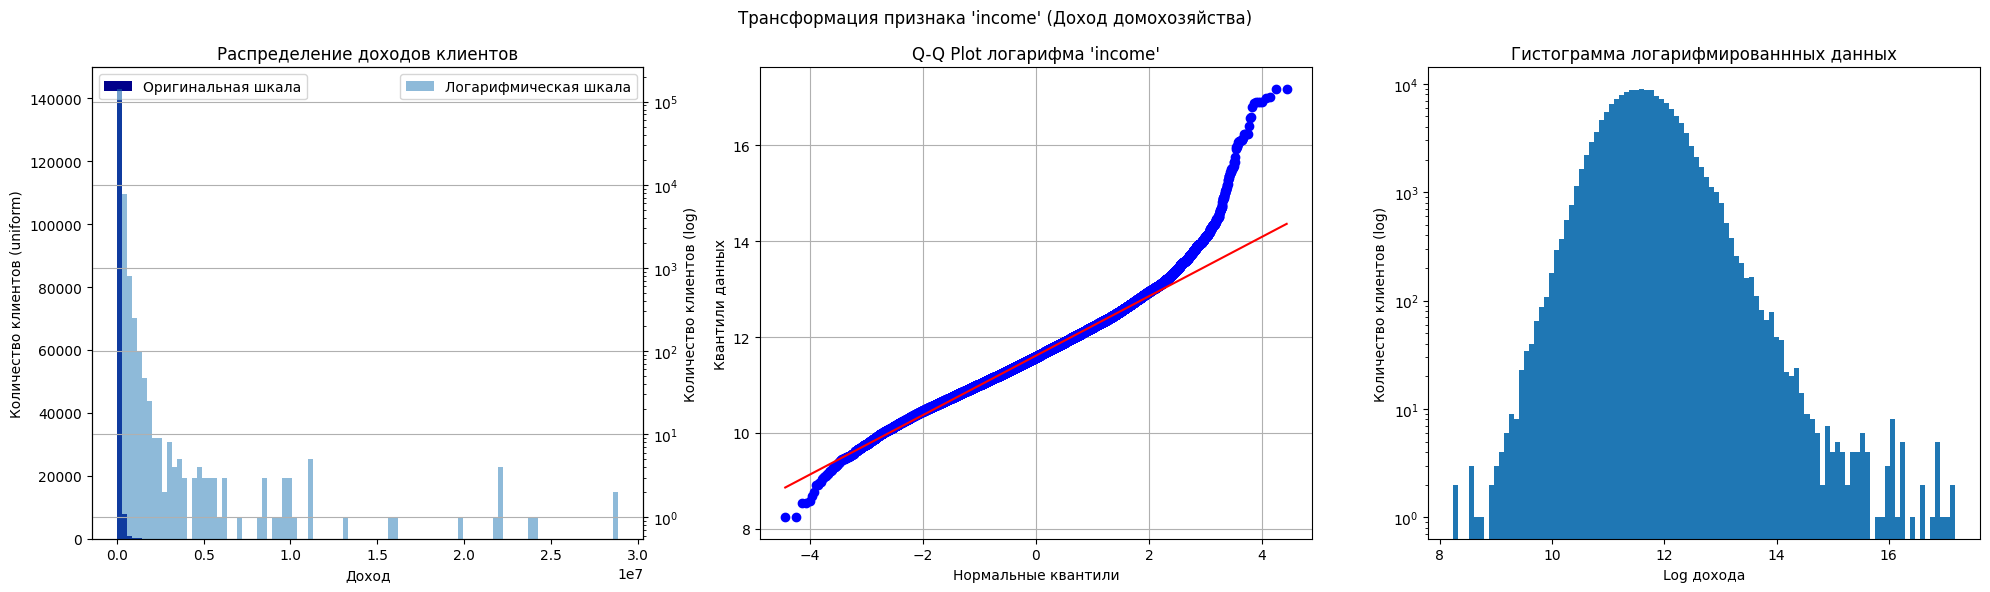

In [18]:
df_incomes = df.groupby('id')['income'].last()

fig, ax = plt.subplots(nrows=1, ncols= 3, figsize=(20, 6))
plt.suptitle(f"Трансформация признака 'income' ({df.attrs['income'][0]})")

plt.subplot(131)

plt.hist(df_incomes, bins=100, color='darkblue', label = 'Оригинальная шкала')
plt.title('Распределение доходов клиентов')
plt.xlabel('Доход')
plt.ylabel('Количество клиентов (uniform)')
plt.legend(loc='upper left')

plt.twinx()
plt.hist(df_incomes, bins=100, alpha=0.5, label = 'Логарифмическая шкала')
plt.yscale('log')
plt.ylabel('Количество клиентов (log)')
plt.grid(True)
plt.legend()

plt.subplot(132)

income_log = np.log(df_incomes).dropna()

stats.probplot(income_log, dist="norm", plot=plt.subplot(132))
plt.title("Q-Q Plot логарифма 'income'")
plt.xlabel('Нормальные квантили')
plt.ylabel('Квантили данных')
plt.grid(True)

plt.subplot(133)

plt.title('Гистограмма логарифмированнных данных')
plt.xlabel('Log дохода')
plt.ylabel('Количество клиентов (log)')
plt.hist(income_log, bins=100, log=True)

plt.tight_layout()
plt.show()

Как и большинство "денежных" признаков (дорогие/дешевые машины/квартиры/доходы) необходимо нормализовать, что достигается простым логарифмированием.  
(Для "деревянных" алгоритмов это необязательно)

##### Определение функции для препроцессинга данных

В целом, у нас сложилось представление, как предобработать данные.  
Средствами pandas проводятся стандартные преобразования:  
 - удаление строк с количеством пропусков более 10
 - фильтрование по признаку актульных клиентов ('ind_deceased' != 'N')
 - на основе 'registration_date' обновляется 'tenure_months'
 - создадим два временных признака, отражающих временную динамику: 'fetch_month', 'fetch_year'
 - заменим пропуски в 'income' средним значением
 - проводится преобразование типов категорий
 - удаляются явно неинформативные признаки
  
Надо отметить, что поскольку у нас данные разрежены со всех сторон (редкие события и дисбаланс продуктов), возможно, можно было бы глубже поисследовать малоинформативные признаки.  Но, поскольку акцент задания делается на построении сервиса, то этими данными мы можем пренебречь.


In [19]:
def process_na(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process the dataframe by removing rows with too many NaN values and those marked as deceased.

    Parameters:
    df (pd.DataFrame): The input dataframe to process.

    Returns:
    pd.DataFrame: The cleaned dataframe with fewer NaN values and no deceased individuals.
    """
    # Keep rows where fewer than 10 NaN values exist and where 'ind_deceased' is 'N'
    df = df[df.isna().sum(axis=1) < 10]
    df = df[df['ind_deceased'] == 'N']
    
    return df


def process_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Perform various transformations on the dataframe, such as calculating the number of products, 
    tenure in months, and filling in missing values.

    Parameters:
    df (pd.DataFrame): The input dataframe to transform.

    Returns:
    pd.DataFrame: The transformed dataframe with calculated features and cleaned data.
    """
    # Calculate the number of products based on columns starting with 'ind_1m_'
    df['number_of_products'] = df[[col for col in df.columns if col.startswith('ind_1m_')]].sum(axis=1)

    # Extract year and month from the 'fetch_date' column
    df['fetch_year'] = df['fetch_date'].dt.year
    df['fetch_month'] = df['fetch_date'].dt.month

    # Calculate tenure in months based on 'fetch_date' and 'registration_date'
    df['tenure_months'] = (
        (df['fetch_date'].dt.year - df['registration_date'].dt.year) * 12
        + (df['fetch_date'].dt.month - df['registration_date'].dt.month)
    )

    # Apply a logarithmic transformation to the 'income' column
    df['income'] = np.log(df['income'])

    # Convert 'client_type_1m' to numeric, replacing any 'P' values with 5
    df['client_type_1m'] = pd.to_numeric(df['client_type_1m'], errors='coerce').replace('P', 5)

    # Map 'client_segment' to numeric values, with a default of 0 for missing values
    df['client_segment'] = df['client_segment'].map({None: 0, '02 - PARTICULARES': 2, '03 - UNIVERSITARIO': 3, '01 - TOP': 1})

    # Fill missing values in specified columns with provided values
    df.fillna({
        'province_code': 0,
        'gender': 'V',
        'client_activity_1m': 'N',
        'entry_channel': 'UNK',
        'income': df['income'].median(),
        'client_type_1m': 0
    }, inplace=True)

    # Convert specified columns to integer type
    columns_to_int = ['age', 'tenure_months', 'ind_new_client', 'client_relationship_status',
                      'ind_client_activity', 'province_code', 'client_type_1m', 'number_of_products']
    df[columns_to_int] = df[columns_to_int].astype(int)

    # Drop unnecessary columns from the dataframe
    df = df.drop(columns=[
        'fetch_date', 'id', 'ind_deceased', 'ind_spouse_employee', 'last_date_as_primary',
        'address_type', 'ind_employee', 'country_of_residence', 'ind_resident', 
        'province_name', 'registration_date'
    ])

    # Fill any remaining NaN values with 0 and return the dataframe
    return df.fillna(0)

Протестируем созданные функции на текущем датасете.

In [20]:
df = process_na(df)
df = process_df(df)

df.head()

,gender,age,ind_new_client,tenure_months,client_relationship_status,client_type_1m,client_activity_1m,ind_foreigner,entry_channel,province_code,...,target__ind_1m_tax_account,target__ind_1m_credit_card,target__ind_1m_securities,target__ind_1m_home_acc,target__ind_1m_salary_acc,target__ind_1m_pension_obligation_account,target__ind_1m_debit_account,number_of_products,fetch_year,fetch_month
0,H,35,0,0,1,1,A,N,KHL,29,...,0,0,0,0,0,0,0,1,2015,1
9,H,23,0,29,1,1,I,N,KHE,10,...,0,0,0,0,0,0,0,1,2015,1
12,H,23,0,29,1,1,A,N,KHE,49,...,0,0,0,0,0,0,1,1,2015,1
32,V,23,0,29,1,1,A,N,KHE,37,...,0,0,0,0,0,0,0,1,2015,1
36,H,23,0,29,1,1,A,N,KHE,27,...,0,0,0,0,0,0,0,1,2015,1


И выведем оставшиеся категориальные признаки, отметив отсутствие пропусков.

In [21]:
features = [col for col in df.columns if not col.startswith('ind_1m_') and col not in targets]

display_statistics(df[features])

,type,types,count,NaNs,zero_values,nunique,unique-top5
gender,object,{str},2411240,0,0,2,"{'V': 1458127, 'H': 953113}"
age,int64,{int64},2411240,0,0,111,"{44: 81427, 43: 81155, 42: 79535, 45: 78965, 4..."
ind_new_client,int64,{int64},2411240,0,2211775,2,"{0: 2211775, 1: 199465}"
tenure_months,int64,{int64},2411240,0,38449,254,"{3: 40317, 1: 40200, 4: 39693, 2: 39585, 0: 38..."
client_relationship_status,int64,{int64},2411240,0,0,2,"{1: 2409606, 99: 1634}"
client_type_1m,int64,{int64},2411240,0,28260,5,"{1: 2380481, 0: 28260, 3: 1905, 2: 467, 4: 127}"
client_activity_1m,object,{str},2411240,0,0,5,"{'A': 2174595, 'I': 206353, 'N': 27845, 'P': 2..."
ind_foreigner,object,{str},2411240,0,0,2,"{'N': 2300585, 'S': 110655}"
entry_channel,object,{str},2411240,0,0,145,"{'KAT': 776385, 'KFC': 718513, 'KHE': 267239, ..."
province_code,int64,{int64},2411240,0,7101,53,"{28: 1029557, 8: 180012, 41: 107524, 46: 10661..."


##### Обзор зависимостей между признаками и таргетом с помощью средств phik, оценка высококардинальных переменных

In [22]:
numerical_features = ['age', 'tenure_months', 'income', 'fetch_year', 'fetch_month', 'number_of_products']

category_features = ['gender', 'ind_new_client', 'client_relationship_status', 'client_type_1m',
       'client_activity_1m', 'ind_foreigner', 'entry_channel', 'province_code', 'ind_client_activity', 'client_segment']

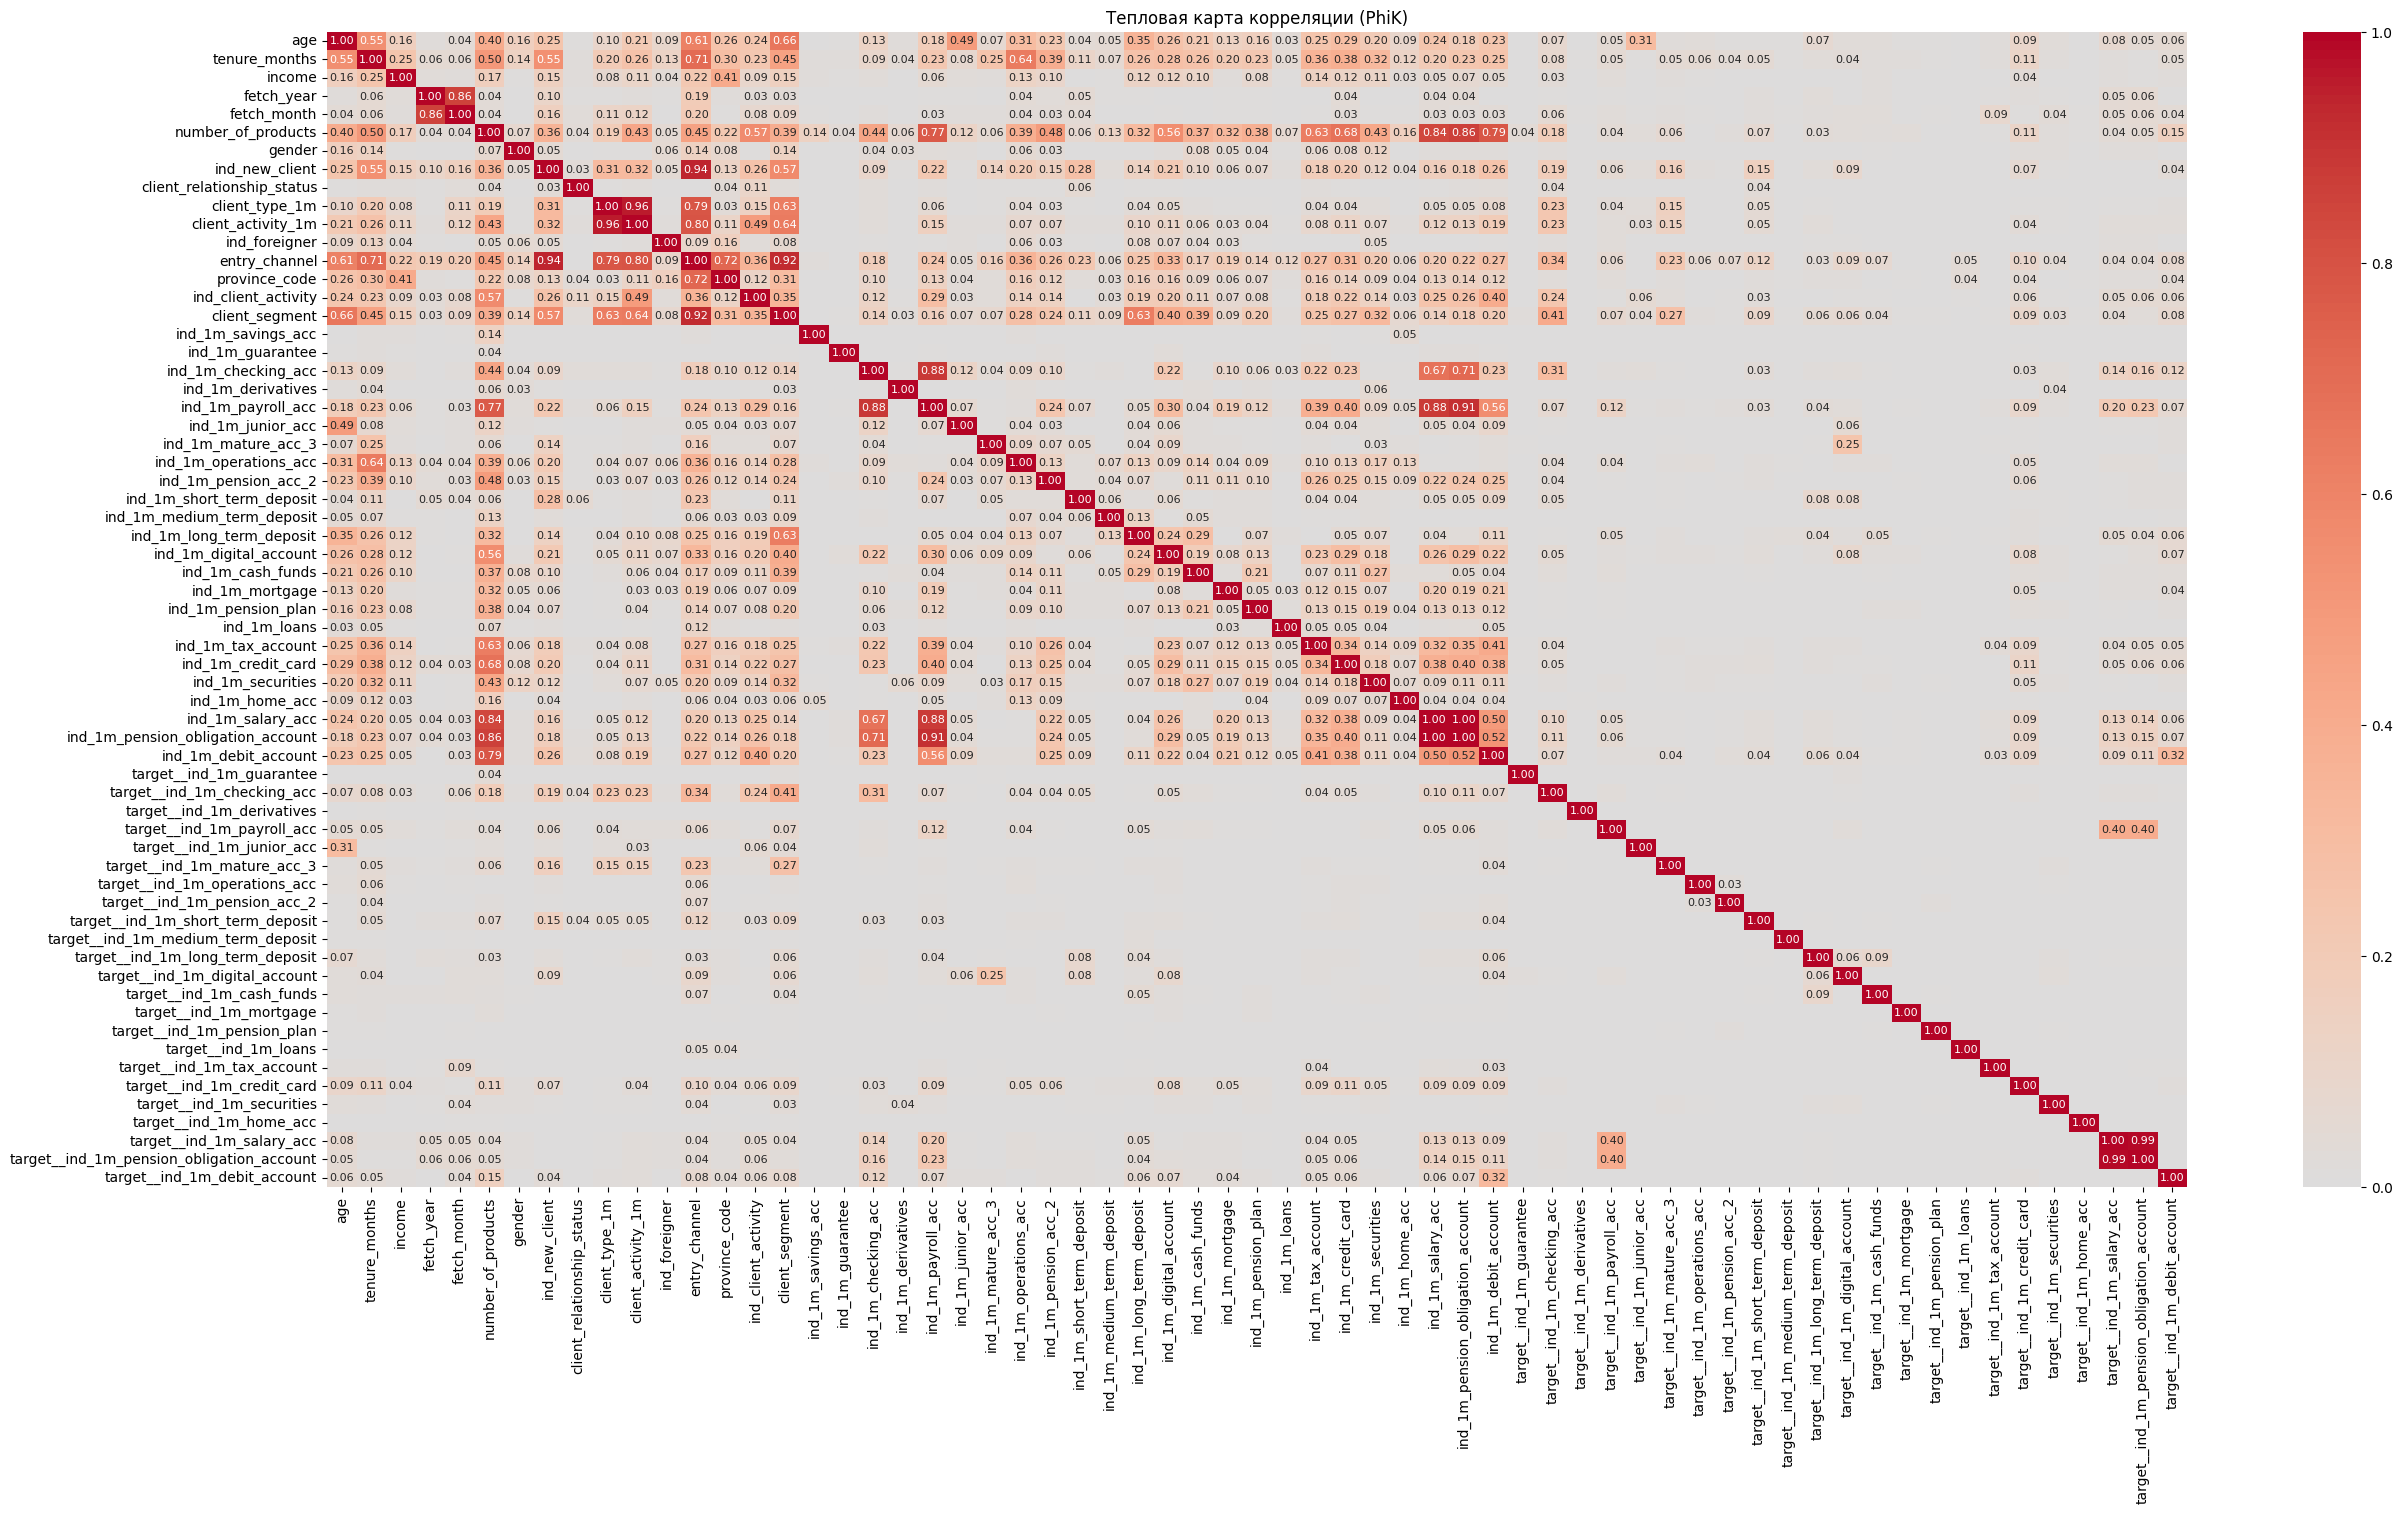

In [23]:
warnings.filterwarnings('ignore')

phik_matrix = (
    df[numerical_features + category_features + product_features + targets]
    .sample(SAMPLE_SIZE, random_state=RANDOM_STATE)
    .phik_matrix(interval_cols=numerical_features)
)
annot_matrix = phik_matrix.copy().applymap(lambda v: f'{v:.2f}' if v > 0.03 else '')

plt.figure(figsize=(30,15))
sns.heatmap(phik_matrix, cmap='coolwarm', center=0, annot=annot_matrix, fmt='', annot_kws={"size": 8})
plt.title('Тепловая карта корреляции (PhiK)')

plt.show()

В общем, картина понятная: наши индикаторы влияют на таргеты слабо.  
Сами таргеты друг от друга почти не зависят.  
Есть сильно влияющие признаки ('client_segment', 'entry_channel'), хорошо объяснимые (группа клиентов, канал привлечения (возможно, рекламная кампания)).  
(Пол, как часто бывает, ни на что не влияет.)  
  
Отметим еще пару дисбалансов:  
 - в сильно влияющем признаке 'entry_channel'  
 - и в слабо влияющем 'province_code'


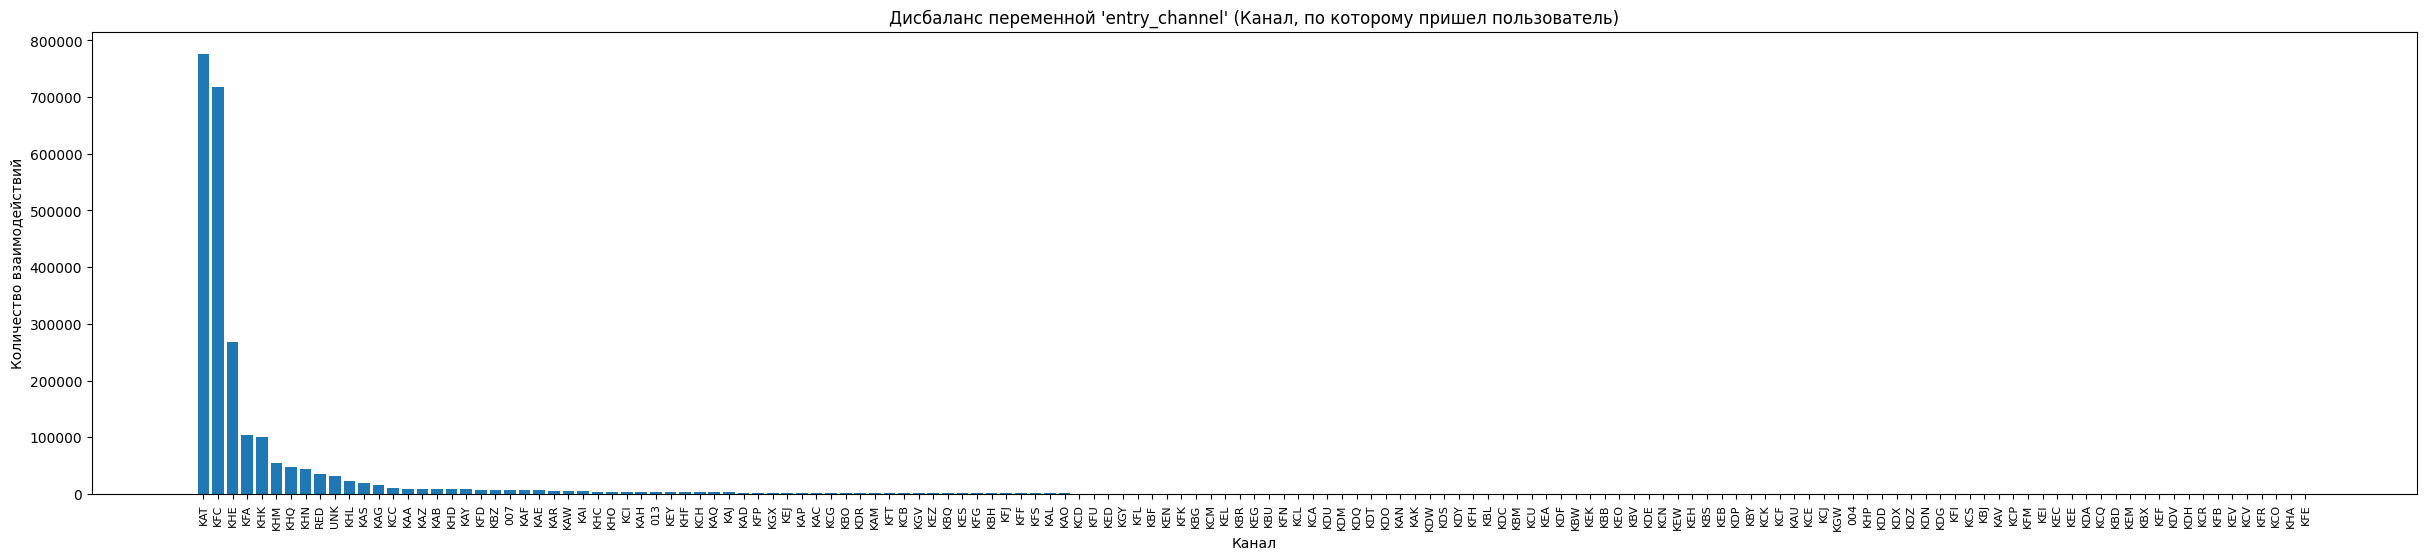

In [24]:
grouped = df.groupby('entry_channel').size().sort_values(ascending=False)

plt.figure(figsize=(30, 6))
plt.title(f"Дисбаланс переменной 'entry_channel' ({df.attrs['entry_channel'][0]})")
plt.xlabel("Канал")
plt.ylabel("Количество взаимодействий")
plt.xticks(rotation=90, fontsize=8)
plt.bar(grouped.index, grouped.values)
plt.show()

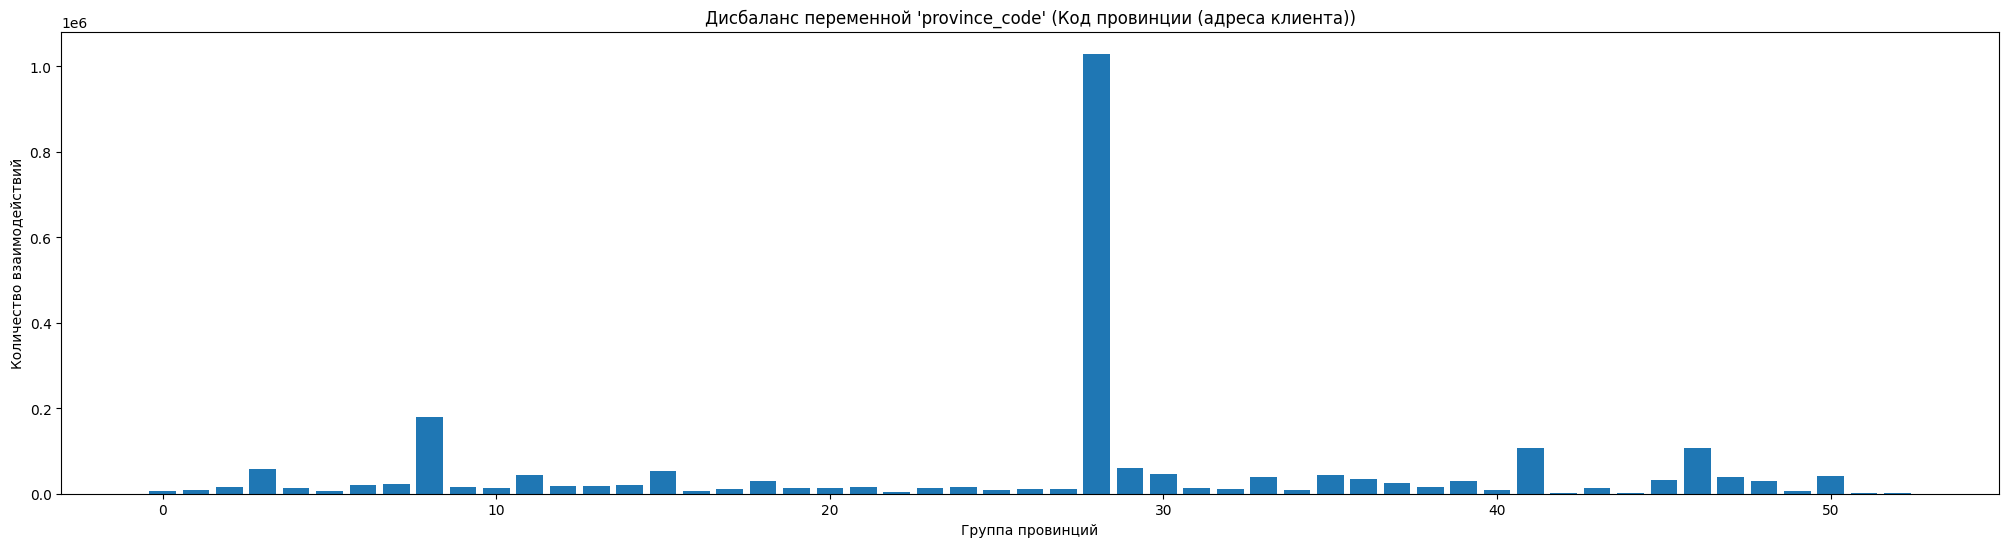

In [25]:
grouped = df.groupby('province_code', observed=True).size().sort_values(ascending=False)

plt.figure(figsize=(25, 6))
plt.title(f"Дисбаланс переменной 'province_code' ({df.attrs['province_code'][0]})")
plt.xlabel("Группа провинций")
plt.ylabel("Количество взаимодействий")
bars = plt.bar(grouped.index, grouped.values)

plt.show()

Принимая во внимание высокую кардинальность переменных и их сильный дисбаланс, выберем кодирование категорий по их частоте в датасете, тогда мы получим один-единственный числовой признак.

##### Проверка препроцессинга, формирование шага предобработки общего пайплайна

Проверим наши функции предобработки, встроив их в step пайплайна и загрузив заново необработанные данные.

In [26]:
def get_X_y(df, targets):
    df = df[df.isna().sum(axis=1) < 10]
    df = df[df['ind_deceased'] == 'N']
    return df.drop(columns= targets), df[targets]

df = pd.read_parquet(DATA_DIR + TRAIN_PARQUET)

X, y = get_X_y(df, df.attrs['target__'])

In [27]:
class DataFrameProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        processed_X = process_df(X.copy())
        if y is not None:
            processed_y = y.loc[processed_X.index]
            return processed_X, processed_y
        return processed_X

processed_df = DataFrameProcessor().fit_transform(X)

numerical_columns = ['age', 'tenure_months', 'income', 'fetch_year', 'fetch_month', 'number_of_products']
freq_encode_columns = ['entry_channel', 'province_code']
one_hot_columns = ['gender', 'client_type_1m', 'client_activity_1m', 'ind_foreigner', 'client_segment']

display('numerical_columns:', display_statistics(processed_df[numerical_columns]))
display('freq_encode_columns:', display_statistics(processed_df[freq_encode_columns]))
display('one_hot_columns:', display_statistics(processed_df[one_hot_columns]))

'numerical_columns:'

,type,types,count,NaNs,zero_values,nunique,unique-top5
age,int64,{int64},2411240,0,0,111,"{44: 81427, 43: 81155, 42: 79535, 45: 78965, 4..."
tenure_months,int64,{int64},2411240,0,38449,254,"{3: 40317, 1: 40200, 4: 39693, 2: 39585, 0: 38..."
income,float64,{float64},2411240,0,0,129555,"{11.595663951150163: 406852, 13.02128527909402..."
fetch_year,int32,{int32},2411240,0,0,2,"{2015: 2022312, 2016: 388928}"
fetch_month,int32,{int32},2411240,0,0,12,"{2: 348622, 1: 343667, 12: 190173, 11: 187706,..."
number_of_products,int64,{int64},2411240,0,84881,16,"{1: 640754, 2: 575943, 3: 363545, 4: 264385, 5..."


'freq_encode_columns:'

,type,types,count,NaNs,zero_values,nunique,unique-top5
entry_channel,object,{str},2411240,0,0,145,"{'KAT': 776385, 'KFC': 718513, 'KHE': 267239, ..."
province_code,int64,{int64},2411240,0,7101,53,"{28: 1029557, 8: 180012, 41: 107524, 46: 10661..."


'one_hot_columns:'

,type,types,count,NaNs,zero_values,nunique,unique-top5
gender,object,{str},2411240,0,0,2,"{'V': 1458127, 'H': 953113}"
client_type_1m,int64,{int64},2411240,0,28260,5,"{1: 2380481, 0: 28260, 3: 1905, 2: 467, 4: 127}"
client_activity_1m,object,{str},2411240,0,0,5,"{'A': 2174595, 'I': 206353, 'N': 27845, 'P': 2..."
ind_foreigner,object,{str},2411240,0,0,2,"{'N': 2300585, 'S': 110655}"
client_segment,int64,{int64},2411240,0,32201,4,"{2: 1620376, 3: 470840, 1: 287823, 0: 32201}"


Настроим стандартную обработку числовых данных, MinMaxScaler - для получения только положительных значений.  
One-hot encoder - для остальных категорий.  
Частотное кодирование - для вышеупомянутых высококардинальных признаков.  
И в качестве модели возьмем CatBoost Classifier (CBC).    
Для этого есть несколько причин:   
 - нет явных зависимостей таргетов от большинства признаков, линейные алгоритмы отработают плохо
 - большинство признаков - категориальные, т.е. алгоритм должен рассматривать их комбинации - а это деревья.  
 - признаков много - значит нужен быстрый алгоритм (алгоритмы глубокого обучения на данном этапе неприменимы)
 - плюс - нативная возможность CBC самостоятельно обрабатывать категории
  
Поскольку тагретов много, то будем использовать MultiOutputClassifier (Classifier chain медленнее, да и применятся в случае взаимной зависимости таргетов, а у нас они практически независимы).

In [28]:
def frequency_encoding(X):
    X_copy = X.copy()
    for col in X_copy.columns:
        freq_map = X_copy[col].value_counts(normalize=True).to_dict()
        X_copy[col] = X_copy[col].map(freq_map)
    return X_copy


column_transformer = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_columns),
        ('onehot', OneHotEncoder(drop='first'), one_hot_columns),
        ('freq', FunctionTransformer(frequency_encoding), freq_encode_columns)
    ], 
    remainder='passthrough',
    force_int_remainder_cols=False,
)

model = Pipeline(steps=[
    ('preprocessor', DataFrameProcessor()),
    ('encoder', column_transformer),
    ('model', MultiOutputClassifier(
        CatBoostClassifier(iterations=100, verbose=0, class_weights = [1, 4], random_state=RANDOM_STATE)
    ))
])

joblib.dump(model, MODEL_DIR + MODEL_PKL)

['models/model.pkl']

##### Итоги проведения исследовательского анализа

- данные из csv файла загружены успешно
- объем данных большой (~ 1.3*10^7 строк, 48 столбцов), датасет разрежен (50-70% повторяющихся и нулевых данных), у некоторых признаков большое количество пропусков
- созданы таргеты для машинного обучения как покупки клиентами продуктов в следующем месяце
- большинство переменных - категориальные
- выбраны метрики для оценки моделирования: Precision, Recall, F1, ROC AUC (micro)
- фильтрование нерелевантных наблюдений сократило объем датасета ((~ 2.3*10^6 строк, ~ 40 столбцов))
- получены зависимости признаков и таргета, эти зависимости неявные и слабые
- создан пайплайн обработки данных - от предобработки до алгоритма ML (Catboost Classifier)
- модель сохранена для дальнейшей работы
- необходимо отметить направления, которых не касался текущий проект:
  - feature engineering, или дизайн признаков. Для повышения качества предсказаний можно генерировать дополнительные признаки из предметной области, т.е. финансовая информация (мы видим только факт покупки продукта, но не можем оценить интенсивность пользования) и дополнительная информация о пользователях. Кроме того, у нас есть данные о взаимодействиях пользователь-продукт, значит, с помощью, например, алгоритма ALS() можно генерировать матрицы и получить дополнительные признаки от рекомендательных алгоритмов (коллаборативная фильтрация): рекомендации продуктов, рекомендации на основе похожих пользователей/продуктов, рекомендации популярных продуктов. Однако каждая новая переменная добавляет столько новых признаков, сколько у нас продуктов (24), поэтому встает вопрос о сокращении размерности.
  - поскольку влияние признаков на таргет неочевидно, может потребоваться генерация признаков (Featuretools, AutoFeat)
  - также не были сгенерированы  традиционные для time-series признаки (скользящие средние, признаки задержки (lag features), последний купленный продукт, частота использования и т.п.)
  - обработка данных по частям: объем данных может быть большой (у нас он достигал 3*10^8), может потребоваться пакетная или распределенная обработка датасета
  - в проекте не сравнивались различные алгоритмы обучения